# Extreme Video Completion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import concurrent.futures as multithreading
from scipy.stats import entropy

In [2]:
class Video:
    
    @staticmethod
    def compress(
        filename, 
        output_dst = None, 
        fraction   = 0.01, 
        verbose    = False
    ):
        def get_indices(
            height, 
            width, 
            fraction
        ):
            def to_2d(
                index
            ):
                return (index // width, index % width)

            samples = np.random.permutation(width * height)[:int(width * height * fraction)]

            indices = [to_2d(index) for index in samples]

            return tuple(zip(*indices))


        def sample_frame(
            frame, 
            fraction
        ):
            height, width, nb_channels = frame.shape

            indices = get_indices(height, width, fraction)

            return np.expand_dims(frame[indices], axis=0)


        seed = np.array(np.random.randint(0, np.iinfo(np.int32).max))
        np.random.seed(seed)
        
        cap = cv2.VideoCapture(filename)
        framerate = np.array(cap.get(cv2.cv2.CAP_PROP_FPS))

        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        start_time = time.time()

        ret, frame = cap.read()
        dimensions = np.array(frame.shape)

        video = sample_frame(frame, fraction)
        curr_frame = 1

        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            sampled_frame = sample_frame(frame, fraction)

            video = np.vstack((video, sampled_frame))

            curr_frame += 1
            if verbose:
                print('Compressing Video: ' + str(int(100 * curr_frame / num_frames)) + 
                      '%\tTime Elapsed: ' + str(int(np.floor(time.time() - start_time))) + ' seconds', end='\r')

        cap.release()
        
        if verbose:
            print('Compressing Video: 100%\tTime Elapsed: ' + str(int(np.floor(time.time() - start_time))) + ' seconds')

        if output_dst is None:
            output_dst = '../Results/CompressedVideos/' + str(int(fraction * 100)) + \
                         'percent/' + filename.split('/')[-1].split('.')[0]
        
        np.savez_compressed(
            output_dst, 
            video=video, 
            dimensions=dimensions, 
            framerate=framerate,
            seed=seed,
            fraction=np.array(fraction)
        )
    
    
    @staticmethod
    def jpg_reconstruct(
        filename, 
        output_dst = 'out.mov', 
        quality    = 80
    ):
        cap = cv2.VideoCapture(filename)
        
        framerate = np.array(cap.get(cv2.cv2.CAP_PROP_FPS))
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        start_time = time.time()
        
        _, frame = cap.read()
        height, width, _ = frame.shape
        
        out = cv2.VideoWriter(
            output_dst, 
            cv2.VideoWriter_fourcc('M','J','P','G'), 
            framerate, 
            (width, height)
        )
        
        jpg_params = [int(cv2.IMWRITE_JPEG_QUALITY), quality]

        _, encoded = cv2.imencode('.jpg', frame, jpg_params)
        decoded = cv2.imdecode(encoded, 1)
        out.write(decoded)
        
        curr_frame = 1
        
        while cap.isOpened():
            ret, frame = cap.read()
            
            if not ret:
                break

            _, encoded = cv2.imencode('.jpg', frame, jpg_params)
            decoded = cv2.imdecode(encoded, 1)
            out.write(decoded)
            
            curr_frame += 1
            print('Compressing with JPG: ' + str(int(100 * curr_frame / num_frames)) +
                  '%\tTime Elapsed: ' + str(int(np.floor(time.time() - start_time))) + ' seconds', end='\r')
        
        print('Compressing with JPG: 100%\tTime Elapsed: ' + str(int(np.floor(time.time() - start_time))) + ' seconds')
            
        out.release()
        cap.release()

    
    @staticmethod
    def psnr(
        original, 
        reconstructed, 
        color_channels = 'bgr'
    ):
        
        cap_original = cv2.VideoCapture(original)
        cap_reconstructed = cv2.VideoCapture(reconstructed)
        
        num_frames_original = int(cap_original.get(cv2.CAP_PROP_FRAME_COUNT))
        num_frames_reconstructed = int(cap_reconstructed.get(cv2.CAP_PROP_FRAME_COUNT))
        num_frames = min(num_frames_original, num_frames_reconstructed)
        
        mse_list = []
        max_pixel_value = np.iinfo(np.uint8).max
        
        start_time = time.time()
        curr_frame = 0
        
        while cap_original.isOpened() and cap_reconstructed.isOpened():
            ret_original, frame_original = cap_original.read()
            ret_reconstructed, frame_reconstructed = cap_reconstructed.read()
            
            if (not ret_original) or (not ret_reconstructed):
                break
            
            height = frame_original.shape[0]
            width = frame_original.shape[1]
            frame_mse = 0
            
            if color_channels == 'bgr':
                nb_channels = frame_original.shape[2]
                total_squared_error = np.sum(np.square(frame_original.astype(int) - 
                                                       frame_reconstructed.astype(int)))
                frame_mse = total_squared_error / (width * height * nb_channels)
            
            elif color_channels == 'ycrcb':
                frame_original = cv2.cvtColor(frame_original, cv2.COLOR_BGR2YCrCb)
                frame_reconstructed = cv2.cvtColor(frame_reconstructed, cv2.COLOR_BGR2YCrCb)
                total_squared_error = np.sum(np.square(frame_original[:,:,0].astype(int) - 
                                                       frame_reconstructed[:,:,0].astype(int)))
                frame_mse = total_squared_error / (width * height)
            
            mse_list.append(frame_mse)
            
            curr_frame += 1
            print('Computing PSNR: ' + str(int(100 * curr_frame / num_frames)) +
                  '%\tTime Elapsed: ' + str(int(np.floor(time.time() - start_time))) + ' seconds', end='\r')
        
        mse = np.mean(mse_list)
        psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
        
        print('Computing PSNR: 100%\tTime Elapsed: ' + str(int(np.floor(time.time() - start_time))) + ' seconds')
        
        cap_original.release()
        cap_reconstructed.release()
        
        return psnr
    
    
    @staticmethod
    def color_distributions(
        filename, 
        window_width, 
        max_num_frames = 100, 
        alpha          = 0.95, 
        color_channels = 'bgr',
        concatenate    = False, 
        seed           = 28374
    ):
        np.random.seed(seed)
        window_overlap = 0.5
        
        uniform = np.ones(np.iinfo(np.uint8).max + 1) / (np.iinfo(np.uint8).max + 1)
        
        cap = cv2.VideoCapture(filename)
        
        ret, frame = cap.read()
        height = frame.shape[0]
        width = frame.shape[1]
        nb_channels = frame.shape[2]
        
        def intervals(
            length
        ):
            return [slice(x, min(x + window_width, length)) for x in 
                    range(0, max(1, length - int(window_width * window_overlap)), 
                          int(window_width * (1 - window_overlap)))]


        def window_color_distributions(
            window
        ):
            if color_channels == 'ycrbr':
                nb_relevant_channels = 1
            else:
                nb_relevant_channels = nb_channels
        
            dist = np.array([alpha * np.histogram(window[:,channel], 
                                                  bins=range(np.iinfo(np.uint8).max + 2), 
                                                  density=True)[0] +
                             (1 - alpha) * uniform
                             for channel in range(nb_relevant_channels)])
            
            if concatenate:
                return dist.flatten()
            else:
                return dist
        
        
        windows = [(y, x) for x in intervals(width) for y in intervals(height)]
        frames_color_distributions = []
        num_frames_processed = 1
        
        window = windows[np.random.randint(0, len(windows))]
        
        frame_color_distributions = [
            window_color_distributions(frame[window].reshape(
                ((window[0].stop - window[0].start) * (window[1].stop - window[1].start), 
                 nb_channels)
            ))
        ]
        
        frames_color_distributions.append(frame_color_distributions)
        
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break
            
            window = windows[np.random.randint(0, len(windows))]
            
            frame_color_distributions = [
                window_color_distributions(frame[window].reshape(
                    ((window[0].stop - window[0].start) * (window[1].stop - window[1].start), 
                     nb_channels)
                ))
            ]
            
            frames_color_distributions.append(frame_color_distributions)
            
            num_frames_processed += 1
            if num_frames_processed >= max_num_frames:
                break

        cap.release()
        
        return np.array(frames_color_distributions)

In [3]:
class Kernels:
    
    @staticmethod
    def kernel_2d(
        kernel_size, 
        sigma
    ):
        center = (kernel_size - 1) / 2
        kernel = np.fromfunction(
            lambda x, y: 
                np.exp( -0.5 * ((x - center) ** 2 + (y - center) ** 2) / (sigma ** 2)), 
            (kernel_size, kernel_size), 
            dtype=float
        )
        return kernel
    
    
    @staticmethod
    def kernel_3d(
        kernel_size, 
        sigma, 
        num_kernels, 
        sigma_time
    ):
        center = (kernel_size - 1) / 2
        kernels = np.fromfunction(
            lambda t, x, y: 
                np.exp( -0.5 * (
                                 (((x - center) ** 2 + (y - center) ** 2) / (sigma ** 2)) + 
                                  ((t ** 2) / (sigma_time ** 2))
                               )
                ), 
            (num_kernels, kernel_size, kernel_size), 
            dtype=float
        )
        return kernels


class CompressedVideo:
    
    def __init__(
        self, 
        filename
    ):
        file_dict = np.load(filename)
        
        self.filename = filename.split('.npz')[0]
        self.height = file_dict['dimensions'][0]
        self.width = file_dict['dimensions'][1]
        self.nb_channels = file_dict['dimensions'][2]
        self.video = file_dict['video']
        self.num_frames = self.video.shape[0]
        self.framerate = file_dict['framerate']
        self.seed = file_dict['seed']
        self.fraction = file_dict['fraction']
        
        # Create indices from seed
        def indices_generator():
            np.random.seed(self.seed)
            for idx in range(self.num_frames):
                samples = np.random.permutation(self.width * self.height)[:int(self.width * self.height * self.fraction)]
                yield tuple(zip(*[(index // self.width, index % self.width) for index in samples]))
        
        self.indices = np.array([i for i in indices_generator()])
        
        
        self.defaults = {}
        self.defaults['sigma']           = np.sqrt((self.height * self.width) / 
                                                   (self.video[0].shape[0] * np.pi))
        self.defaults['kernel_size']     = 2 * (int(0.5 + 3 * self.defaults['sigma']) + 2) + 1
        self.defaults['num_time_frames'] = 99
        self.defaults['output_dst']      = self.filename + '_reconstructed.mov'
        self.defaults['multithreaded']   = True
        self.defaults['alpha']           = 0.95
        self.defaults['beta']            = 14
        self.defaults['window_width']    = {
            '0.01': 240,
            '0.02': 160,
            '0.03': 140,
            '0.04': 110,
            '0.05': 100,
            '0.06': 80,
            '0.07': 75,
            '0.08': 70
        }
        self.defaults['window_overlap']  = 0.5
    
    
    def reconstruct(
        self, 
        algorithm      = 'efan2d', 
        color_channels = 'bgr', 
        verbose        = False, 
        filter_type    = 'normal',
        avg_method     = 'normal',
        kernel_type    = 'constant',
        **kwargs
    ):
        """
        TODO complete description
        """
        
        if 'kernel_size' in kwargs:
            kernel_size = kwargs['kernel_size']
        else:
            kernel_size = self.defaults['kernel_size']
        
        if 'sigma' in kwargs:
            sigma = kwargs['sigma']
        else:
            sigma = self.defaults['sigma']
        
        if 'num_time_frames' in kwargs:
            num_time_frames = kwargs['num_time_frames']
        else:
            num_time_frames = self.defaults['num_time_frames']
        
        if 'output_dst' in kwargs:
            output_dst = kwargs['output_dst']
        else:
            output_dst = self.defaults['output_dst']
        
        if 'multithreaded' in kwargs:
            multithreaded = kwargs['multithreaded']
        else:
            multithreaded = self.defaults['multithreaded']
        
        if 'alpha' in kwargs:
            alpha = kwargs['alpha']
        else:
            alpha = self.defaults['alpha']
        
        if 'beta' in kwargs:
            beta = kwargs['beta']
        else:
            beta = self.defaults['beta']
        
        if 'window_width' in kwargs:
            window_width = kwargs['window_width']
        else:
            window_width = self.defaults['window_width'][str(self.fraction)]
        
        if 'window_overlap' in kwargs:
            window_overlap = kwargs['window_overlap']
        else:
            window_overlap = self.defaults['window_overlap']
        
        
        def display_progress(
            frame_index, 
            start_time, 
            filter_times, 
            complete = False
        ):
            if verbose:
                print('Reconstructing Video: ' + str(int(100 * frame_index / self.num_frames)) + '% ' + 
                      '\tTime Elapsed: ' + str(np.round(time.time() - start_time, 2)) + ' seconds ' +
                      '\tFilter Time: '  + str(np.round(np.sum(filter_times), 2)) + ' seconds', end='\r')

                if complete:
                    print('')
        
        
        def prepare_frame(
            frame_index
        ):
            frame = self.video[frame_index]
            indices = self.indices[frame_index]

            black_frame = np.zeros((self.height, self.width, self.nb_channels))
                
            if color_channels == 'ycrcb':
                frame = cv2.cvtColor(np.expand_dims(frame, axis=0), cv2.COLOR_BGR2YCrCb)[0]
            
            black_frame[tuple(indices)] = frame

            new_channel = np.zeros((self.height, self.width, 1)) + 1e-10 # To avoid division by zero
            new_channel[tuple(indices)] = 1.0

            augmented_frame = np.append(black_frame, new_channel, axis=2)
            
            return augmented_frame
        
        
        def normalize_frame(
            frame
        ):
            for i in range(self.nb_channels):
                frame[:,:,i] /= frame[:,:,-1]

            reconstructed_frame = (frame[:,:,:-1] + 0.5).astype(np.uint8)
            
            return reconstructed_frame
        
        
        def efan2d(
            output
        ):
            """
            EFAN2D Algorithm
            """
            
            filter_times = []

            def filter_frame(
                frame_index, 
                kernel
            ):
                augmented_frame = prepare_frame(frame_index)

                st = time.time()
                filtered = cv2.filter2D(augmented_frame, -1, kernel, 
                                        borderType=cv2.BORDER_CONSTANT)
                filter_times.append(time.time() - st)
                
                return filtered
            
            
            def reconstruct_frame(
                frame_index, 
                kernel
            ):
                filtered = filter_frame(frame_index, kernel)
                reconstructed_frame = normalize_frame(filtered)
                
                return reconstructed_frame
            
            
            start_time = time.time()
            
            kernel = Kernels.kernel_2d(kernel_size, sigma)
            
            display_progress(0, start_time, filter_times)
            
            for frame_index in range(self.num_frames):
                reconstructed_frame = reconstruct_frame(frame_index, kernel)
                
                if color_channels == 'ycrcb':
                    reconstructed_frame = cv2.cvtColor(reconstructed_frame, cv2.COLOR_YCrCb2BGR)
                
                output.write(reconstructed_frame)
                display_progress(frame_index, start_time, filter_times)
            
            display_progress(self.num_frames, start_time, filter_times, complete=True)


        def efan3d(
            output
        ):
            """
            EFAN3D Algorithm
            """
            
            num_kernels = (num_time_frames + 1) // 2
            sigma_time = (num_kernels - 1) / 6
            
            filter_times = []
            
            def filter_frame(
                frame_index, 
                kernels
            ):
                augmented_frame = prepare_frame(frame_index)

                st = time.time()
                
                if multithreaded:
                    filtered_frame = [None for i in range(num_kernels)]

                    def apply_kernel(
                        kernel_index
                    ):
                        filtered = cv2.filter2D(augmented_frame, -1, kernels[kernel_index], 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_frame[kernel_index] = filtered

                    with multithreading.ThreadPoolExecutor(max_workers=num_kernels) as executor:
                        executor.map(apply_kernel, range(num_kernels))
                
                else:
                    filtered_frame = []
                    for kernel in kernels:
                        filtered = cv2.filter2D(augmented_frame, -1, kernel, 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_frame.append(filtered)
                
                filter_times.append(time.time() - st)
                
                return filtered_frame
            
            
            def reconstruct_frame(
                frame_index, 
                filtered_frames
            ):
                filtered_sum = np.zeros((self.height, self.width, self.nb_channels + 1))
            
                nb_past_frames = min(frame_index, num_kernels - 1)
                for idx in range(nb_past_frames):
                    filtered_sum += filtered_frames[idx][nb_past_frames - idx]

                nb_future_frames = min(self.num_frames - frame_index, num_kernels)
                for idx in range(nb_future_frames):
                    filtered_sum += filtered_frames[min(frame_index, num_kernels - 1) + idx][idx]
                
                reconstructed_frame = normalize_frame(filtered_sum)
                
                return reconstructed_frame
            
            
            start_time = time.time()
            
            kernels = Kernels.kernel_3d(kernel_size, sigma, num_kernels, sigma_time)
            
            filtered_frames = []
            
            display_progress(0, start_time, filter_times)
            
            for frame_index in range(self.num_frames):
                
                if frame_index == 0:
                    for idx in range(num_kernels):
                        filtered_frames.append(filter_frame(idx, kernels))
                        
                elif frame_index < num_kernels:
                    filtered_frames.append(filter_frame((num_kernels - 1) + frame_index, kernels))
                    
                elif frame_index <= self.num_frames - num_kernels:
                    filtered_frames.append(filter_frame((num_kernels - 1) + frame_index, kernels))
                    filtered_frames = filtered_frames[1:]
                    
                else:
                    filtered_frames = filtered_frames[1:]
                
                reconstructed_frame = reconstruct_frame(frame_index, filtered_frames)
                
                if color_channels == 'ycrcb':
                    reconstructed_frame = cv2.cvtColor(reconstructed_frame, cv2.COLOR_YCrCb2BGR)
                
                output.write(reconstructed_frame)
                
                display_progress(frame_index, start_time, filter_times)
            
            display_progress(self.num_frames, start_time, filter_times, complete=True)
        
        
        def adefan(
            output
        ):
            """
            ADEFAN Algorithm
            """
            
            num_kernels = (num_time_frames + 1) // 2
            sigma_time = (num_kernels - 1) / 6
            uniform = np.ones(np.iinfo(np.uint8).max + 1) / (np.iinfo(np.uint8).max + 1)
            
            window_kernel = Kernels.kernel_2d(window_width, window_width / 6)
            
            filter_times = []
            
            def intervals(
                length
            ):
                return [slice(x, min(x + window_width, length)) for x in 
                        range(0, max(1, length - int(window_width * window_overlap)), 
                              int(window_width * (1 - window_overlap)))]
            
            
            def window_color_distributions(
                window
            ):
                if color_channels == 'ycrbr':
                    nb_relevant_channels = 1
                else:
                    nb_relevant_channels = self.nb_channels

                dist = np.array([alpha * np.histogram(window[:,channel], 
                                                      bins=range(np.iinfo(np.uint8).max + 2), 
                                                      density=True)[0] +
                                 (1 - alpha) * uniform
                                 for channel in range(nb_relevant_channels)])

                return dist.flatten()
            
            
            def preprocess_frame(
                frame_index, 
                windows
            ):
                augmented_frame = prepare_frame(frame_index)
                
                frame_color_distributions = [
                    window_color_distributions(
                        augmented_frame[window][augmented_frame[window][:,:,-1] == 1][:,:-1]
                    ) for window in windows
                ]
                
                return augmented_frame, frame_color_distributions
            
            
            def compute_max_divergence(
                frame_index, 
                frames_color_distributions
            ):
                curr_frame_index = min(frame_index, num_kernels - 1)
                curr_frame_distributions = frames_color_distributions[curr_frame_index]
                num_windows = len(curr_frame_distributions)
                
                max_frame_index = min(curr_frame_index + num_kernels, 
                                      len(frames_color_distributions))
                
                future_div_max = np.full(num_windows, -1.0)
                
                for window_idx in range(num_windows):
                    for idx in range(curr_frame_index + 1, max_frame_index):
                        div = entropy(curr_frame_distributions[window_idx], 
                                      frames_color_distributions[idx][window_idx])

                        if div < future_div_max[window_idx]:
                            break
                        else:
                            future_div_max[window_idx] = div
                
                future_div_max[future_div_max == -1] = np.finfo(np.float32).max
                
                min_frame_index = max(0, curr_frame_index - num_kernels + 1)
                
                past_div_max = np.full(num_windows, -1.0)
                
                for window_idx in range(num_windows):
                    for idx in range(min_frame_index, curr_frame_index):
                        div = entropy(curr_frame_distributions[window_idx],
                                      frames_color_distributions[idx][window_idx])

                        if div < past_div_max[window_idx]:
                            break
                        else:
                            past_div_max[window_idx] = div
                
                past_div_max[past_div_max == -1] = np.finfo(np.float32).max
                
                return past_div_max, future_div_max
            
            
            def div_to_num_frames(
                past_div_max, 
                future_div_max
            ):
                conversion = lambda div: int(np.ceil(num_kernels / (1 + beta * div))) - 1
                
                num_past_frames = np.vectorize(conversion)(past_div_max)
                num_future_frames = np.vectorize(conversion)(future_div_max)
                
                return num_past_frames, num_future_frames
            
            
            def normalize_window(
                filtered_window
            ):
                kernel = window_kernel[:filtered_window.shape[0], :filtered_window.shape[1]]
                
                for i in range(self.nb_channels):
                    filtered_window[:,:,i] /= filtered_window[:,:,-1]
                    filtered_window[:,:,i] *= kernel
                
                filtered_window[:,:,-1] = kernel
                
                return filtered_window
            
            
            def reconstruct_frame_by_window(
                frame_index, 
                augmented_frames, 
                windows, 
                num_past_frames, 
                num_future_frames,
                kernel_type = 'constant',
                avg_method  = 'gaussian'
            ):  
                if kernel_type == 'constant':
                    kernels = Kernels.kernel_3d(kernel_size, sigma, num_kernels, sigma_time)
                
                filtered_sum = np.zeros((self.height, self.width, self.nb_channels + 1))
                
                for window, window_num_past_frames, window_num_future_frames in \
                    zip(windows, num_past_frames, num_future_frames):
                    
                    st = time.time()
                    
                    if kernel_type == 'variable':
                        kernels = Kernels.kernel_3d(
                            kernel_size, 
                            sigma, 
                            window_num_past_frames + 1, 
                            max(window_num_past_frames / 6, 0.01)
                        )
                    
                    curr_frame_idx = min(frame_index, num_kernels - 1)
                    first_past_frame_idx = max(curr_frame_idx - window_num_past_frames, 0)
                    past_frames = [f for f in reversed(augmented_frames[first_past_frame_idx:curr_frame_idx])]
                    past_filtered_windows = [None] * len(past_frames)
                    
                    if multithreaded:
                        def filter_past_frame(
                            past_frame_idx
                        ):
                            filtered_window = cv2.filter2D(past_frames[past_frame_idx][window], -1, 
                                                           kernels[past_frame_idx + 1], 
                                                           borderType=cv2.BORDER_CONSTANT)
                            past_filtered_windows[past_frame_idx] = filtered_window
                        
                        with multithreading.ThreadPoolExecutor(max_workers=max(len(past_frames), 1)) as executor:
                            executor.map(filter_past_frame, range(len(past_frames)))
                        
                    else:
                        for idx, past_frame in enumerate(past_frames):
                            filtered_window = cv2.filter2D(past_frame[window], -1, kernels[idx + 1], 
                                                           borderType=cv2.BORDER_CONSTANT)
                            past_filtered_windows[idx] = filtered_window
                    
                    if kernel_type == 'variable':
                        kernels = Kernels.kernel_3d(
                            kernel_size, 
                            sigma, 
                            window_num_future_frames + 1, 
                            max(window_num_future_frames / 6, 0.01)
                        )
                    
                    last_future_frame_idx = min(curr_frame_idx + window_num_future_frames, len(augmented_frames) - 1)
                    future_frames = augmented_frames[curr_frame_idx:last_future_frame_idx + 1]
                    future_filtered_windows = [None] * len(future_frames)
                    
                    if multithreaded:
                        def filter_future_frame(
                            future_frame_idx
                        ):
                            filtered_window = cv2.filter2D(future_frames[future_frame_idx][window], -1, 
                                                           kernels[future_frame_idx], 
                                                           borderType=cv2.BORDER_CONSTANT)
                            future_filtered_windows[future_frame_idx] = filtered_window
                        
                        with multithreading.ThreadPoolExecutor(max_workers=max(len(future_frames), 1)) as executor:
                            executor.map(filter_future_frame, range(len(future_frames)))
                        
                    else:
                        for idx, future_frame in enumerate(future_frames):
                            filtered_window = cv2.filter2D(future_frame[window], -1, kernels[idx], 
                                                           borderType=cv2.BORDER_CONSTANT)
                            future_filtered_windows[idx] = filtered_window
                    
                    filter_times.append(time.time() - st)
                    
                    filtered_sum_window = np.sum(past_filtered_windows, axis=0) + \
                                          np.sum(future_filtered_windows, axis=0)
                    
                    if avg_method == 'gaussian':
                        filtered_sum_window = normalize_window(filtered_sum_window)
                    
                    filtered_sum[window] += filtered_sum_window
                
                filtered_frame = normalize_frame(filtered_sum)
                    
                return filtered_frame
            
            
            def reconstruct_frame(
                frame_index, 
                augmented_frames, 
                windows, 
                num_past_frames, 
                num_future_frames,
                kernel_type = 'constant',
                avg_method  = 'gaussian'
            ):
                kernels = Kernels.kernel_3d(kernel_size, sigma, num_kernels, sigma_time)
                
                filtered_sum = np.zeros((self.height, self.width, self.nb_channels + 1))
                
                max_num_past_frames = max(num_past_frames)
                max_num_future_frames = max(num_future_frames)
                
                curr_frame_idx = min(frame_index, num_kernels - 1)
                
                st = time.time()
                
                first_past_frame_idx = max(curr_frame_idx - max_num_past_frames, 0)
                filtered_past_frames = [None for i in range(curr_frame_idx - first_past_frame_idx)]
                past_frames = [f for f in reversed(augmented_frames[first_past_frame_idx:curr_frame_idx])]
                
                if multithreaded:
                    def filter_past_frame(
                        past_frame_idx
                    ):
                        filtered = cv2.filter2D(past_frames[past_frame_idx], -1, 
                                                kernels[past_frame_idx + 1], 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_past_frames[past_frame_idx] = filtered
                    
                    with multithreading.ThreadPoolExecutor(max_workers=max(max_num_past_frames, 1)) as executor:
                        executor.map(filter_past_frame, range(len(past_frames)))
                                     
                else:
                    for idx, past_frame in enumerate(past_frames):
                        filtered = cv2.filter2D(past_frame, -1, kernels[idx + 1], 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_past_frames[idx] = filtered
                
                last_future_frame_idx = min(curr_frame_idx + max_num_future_frames, len(augmented_frames) - 1)
                filtered_future_frames = [None for i in range(last_future_frame_idx - curr_frame_idx + 1)]
                future_frames = augmented_frames[curr_frame_idx:last_future_frame_idx + 1]
                
                if multithreaded:
                    def filter_future_frame(
                        future_frame_idx
                    ):
                        filtered = cv2.filter2D(future_frames[future_frame_idx], -1, 
                                                kernels[future_frame_idx], 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_future_frames[future_frame_idx] = filtered
                    
                    with multithreading.ThreadPoolExecutor(max_workers=max(max_num_future_frames, 1)) as executor:
                        executor.map(filter_future_frame, range(len(future_frames)))
                
                else:
                    for idx, future_frame in enumerate(future_frames):
                        filtered = cv2.filter2D(future_frame, -1, kernels[idx], 
                                                borderType=cv2.BORDER_CONSTANT)
                        filtered_future_frames[idx] = filtered
                
                filter_times.append(time.time() - st)
                
                for window, window_num_past_frames, window_num_future_frames in \
                    zip(windows, num_past_frames, num_future_frames):
                    
                    filtered_sum_window = np.zeros((window[0].stop - window[0].start, 
                                                    window[1].stop - window[1].start,
                                                    self.nb_channels + 1))
                    
                    for past_frame in filtered_past_frames[:window_num_past_frames]:
                        filtered_sum_window += past_frame[window]
                    
                    for future_frame in filtered_future_frames[:window_num_future_frames + 1]:
                        filtered_sum_window += future_frame[window]
                    
                    if avg_method == 'gaussian':
                        filtered_sum_window = normalize_window(filtered_sum_window)
                    
                    filtered_sum[window] += filtered_sum_window
                
                filtered_frame = normalize_frame(filtered_sum)
                    
                return filtered_frame
            
            
            start_time = time.time()
            
            windows = [(y, x) for x in intervals(self.width) for y in intervals(self.height)]
            augmented_frames = []
            frames_color_distributions = []
            
            for frame_index in  range(self.num_frames):
                
                if frame_index == 0:
                    for idx in range(num_kernels):
                        augmented_frame, frame_color_distributions = preprocess_frame(idx, windows)
                        
                        augmented_frames.append(augmented_frame)
                        frames_color_distributions.append(frame_color_distributions)
                
                elif frame_index < num_kernels:
                    augmented_frame, frame_color_distributions = \
                        preprocess_frame((num_kernels - 1) + frame_index, windows)
                    
                    augmented_frames.append(augmented_frame)
                    frames_color_distributions.append(frame_color_distributions)
                    
                elif frame_index <= self.num_frames - num_kernels:
                    augmented_frame, frame_color_distributions = \
                        preprocess_frame((num_kernels - 1) + frame_index, windows)
                    
                    augmented_frames.append(augmented_frame)
                    frames_color_distributions.append(frame_color_distributions)
                    
                    augmented_frames           = augmented_frames[1:]
                    frames_color_distributions = frames_color_distributions[1:]
                    
                else:
                    augmented_frames           = augmented_frames[1:]
                    frames_color_distributions = frames_color_distributions[1:]
                
                past_div_max, future_div_max = \
                    compute_max_divergence(frame_index, frames_color_distributions)
                
                num_past_frames, num_future_frames = \
                    div_to_num_frames(past_div_max, future_div_max)
                
                if filter_type == 'window':
                    reconstructed_frame = reconstruct_frame_by_window(
                                            frame_index, 
                                            augmented_frames, 
                                            windows, 
                                            num_past_frames, 
                                            num_future_frames,
                                            kernel_type=kernel_type,
                                            avg_method=avg_method
                                          )
                else:
                    reconstructed_frame = reconstruct_frame(
                                            frame_index, 
                                            augmented_frames, 
                                            windows, 
                                            num_past_frames, 
                                            num_future_frames,
                                            avg_method=avg_method
                                          )
                
                if color_channels == 'ycrcb':
                    reconstructed_frame = cv2.cvtColor(reconstructed_frame, cv2.COLOR_YCrCb2BGR)
                
                reconstructed_frame[tuple(self.indices[frame_index])] = self.video[frame_index]
                
                output.write(reconstructed_frame)
                
                display_progress(frame_index, start_time, filter_times)
            display_progress(self.num_frames, start_time, filter_times, complete=True)
                
            
            
            
            #############################################
        
        
        output = cv2.VideoWriter(
                    output_dst, 
                    cv2.VideoWriter_fourcc('M','J','P','G'), 
                    self.framerate, 
                    (self.width, self.height)
                 )
        
        if algorithm == 'efan2d':
            efan2d(output)
        elif algorithm == 'efan3d':
            efan3d(output)
        elif algorithm == 'adefan':
            adefan(output)
        
        output.release()
    
    
    def color_distributions(
        self, 
        window_width, 
        max_num_frames = 100, 
        alpha          = 0.95, 
        color_channels = 'bgr',
        concatenate    = False,
        seed           = 28374
    ):
        np.random.seed(seed)
        window_overlap = self.defaults['window_overlap']
        
        uniform = np.ones(np.iinfo(np.uint8).max + 1) / (np.iinfo(np.uint8).max + 1)

        def prepare_frame(
            frame_index
        ):
            frame = self.video[frame_index]
            indices = self.indices[frame_index]

            black_frame = np.zeros((self.height, self.width, self.nb_channels))
                
            if color_channels == 'ycrcb':
                frame = cv2.cvtColor(np.expand_dims(frame, axis=0), cv2.COLOR_BGR2YCrCb)[0]
            
            black_frame[tuple(indices)] = frame

            new_channel = np.zeros((self.height, self.width, 1)) + 1e-10 # To avoid division by zero
            new_channel[tuple(indices)] = 1.0

            augmented_frame = np.append(black_frame, new_channel, axis=2)
            
            return augmented_frame
        
        
        def intervals(
            length
        ):
            return [slice(x, min(x + window_width, length)) for x in 
                    range(0, max(1, length - int(window_width * window_overlap)), 
                          int(window_width * (1 - window_overlap)))]


        def window_color_distributions(
            window
        ):
            if color_channels == 'ycrbr':
                nb_relevant_channels = 1
            else:
                nb_relevant_channels = self.nb_channels
                
            dist = np.array([alpha * np.histogram(window[:,channel], 
                                                  bins=range(np.iinfo(np.uint8).max + 2), 
                                                  density=True)[0] +
                             (1 - alpha) * uniform
                             for channel in range(nb_relevant_channels)])
            
            if concatenate:
                return dist.flatten()
            else:
                return dist

        
        def preprocess_frame(
            frame_index, 
            windows
        ):
            augmented_frame = prepare_frame(frame_index)
            
            window = windows[np.random.randint(0, len(windows))]

            frame_color_distributions = [
                window_color_distributions(
                    augmented_frame[window][augmented_frame[window][:,:,-1] == 1][:,:-1]
                )
            ]

            return augmented_frame, frame_color_distributions
        
        
        windows = [(y, x) for x in intervals(self.width) for y in intervals(self.height)]
        frames_color_distributions = []
        
        for frame_index in range(min(max_num_frames, self.num_frames)):
            
            _, frame_color_distributions = preprocess_frame(frame_index, windows)
            frames_color_distributions.append(frame_color_distributions)
        
        return np.array(frames_color_distributions)
    

# Optimization Benchmark

In [29]:
##################################
##### Optimization Benchmark #####
##################################

height = 720
width = 1280
num_channels = 3
length = 38 #seconds
framerate = 24
num_frames = length * framerate
anchor_x = 400
anchor_y = 400
num_rand_pixels = (height * width) // 100

kernel_size = 71
kernel = Kernels.kernel_2d(kernel_size, 20)
r = (kernel_size - 1) // 2

###########################
##### Naive Operation #####
###########################

st = time.time()

kernel_dict = {}
for i in range(256):
    kernel_dict[i] = kernel * i

filtered = np.zeros((height, width, num_channels + 1));

for idx in range(num_rand_pixels // 100):
    k = kernel_dict[np.random.randint(0,256)]
    for c in range(num_channels + 1):
        for y in range(kernel_size):
            for x in range(kernel_size):
                filtered[anchor_x-r+y,anchor_y-r+x,c] += k[x,y]
tot_time_naive = (time.time() - st) * num_frames * 100
print('Naive python operations / array indexing:', np.around(tot_time_naive / 3600, 1), 'hours')

###########################
##### Numpy Optimized #####
###########################

st = time.time()

filtered = filtered = np.zeros((height, width, num_channels + 1));

kernel_dict = {}
for i in range(256):
    kernel_dict[i] = kernel * i

for i in range(num_rand_pixels):
    for c in range(num_channels + 1):
        filtered[anchor_y-r:anchor_y+r+1, anchor_x-r:anchor_x+r+1, c] += kernel_dict[np.random.randint(0,256)]

tot_time_numpy = (time.time() - st) * num_frames
print('Numpy (C) operations / array indexing:', np.around(tot_time_numpy / 60, 1), 'minutes')
print('Numpy speedup:', np.around(tot_time_naive / tot_time_numpy, 1), 'times faster')

Naive python operations / array indexing: 29.6 hours
Numpy (C) operations / array indexing: 9.6 minutes
Numpy speedup: 185.0 times faster


The equivalent of the MATLAB / C++ implementation would take over 29 hours to reconstruct the video using python operations and almost 10 minutes using numpy operations. Since numpy is already written in C there isn't much more to do to speed up the additions / multiplications / array indexing. Even using numpy this is still more than 4 times slower than using opencv to interpolate the value of each pixel (Probably because of the time gained by using filter2D which uses the FFT algorithm).

# MATLAB / Python Comparison

In [22]:
######################################
##### MATLAB / Python comparison #####
######################################

import scipy.io as sio

frame = cv2.imread('Resources/ImageComparison/lena.png')
width = frame.shape[1]
height = frame.shape[0]
nb_channels = frame.shape[2]

randvec = sio.loadmat('Resources/ImageComparison/randvec.mat')['randind'][0] - 1 # MATLAB indexing starts at 1

st = time.time() # Start counting time

indices = [(index % height, index // height) for index in randvec] # MATLAB is column major so we convert to row major
indices = tuple(zip(*indices))

black_frame = np.zeros((height, width, nb_channels))
black_frame[indices] = frame[indices]

new_channel = np.zeros((height, width, 1)) + 1e-10 # To avoid division by zero
new_channel[indices] = 1.0

augmented_frame = np.append(black_frame, new_channel, axis=2)

sigma = np.sqrt((height * width) / (len(indices[0]) * np.pi))
kernel_size = 2 * (int(0.5 + 3 * sigma) + 2) + 1

kernel = Kernels.kernel_2d(kernel_size, sigma)

filtered = cv2.filter2D(augmented_frame, -1, kernel, borderType=cv2.BORDER_CONSTANT)
for i in range(nb_channels):
    filtered[:,:,i] /= filtered[:,:,-1]
reconstructed_frame = (filtered[:,:,:-1] + 0.5).astype(np.uint8)

print('Total time elapsed', time.time() - st, 'seconds')

cv2.imwrite('Resources/ImageComparison/lena_python.png', reconstructed_frame);

Total time elapsed 0.05006265640258789 seconds


Our method takes the same amount of time as the MATLAB / C++ implementation to reconstruct the image

In [23]:
lena_matlab = cv2.imread('Resources/ImageComparison/lena_matlab.png')
lena_python = cv2.imread('Resources/ImageComparison/lena_python.png')

print('Number of different channel values:', np.count_nonzero(lena_matlab - lena_python))

Number of different channel values: 2


Only 6 channel values differ between the two images so the methods are equivalent (those values are probably because of different rounding / precision between python and C++)

In [148]:
lena_original = cv2.imread('Resources/ImageComparison/lena.png')
lena_matlab = cv2.imread('Resources/ImageComparison/lena_matlab.png')
lena_python = cv2.imread('Resources/ImageComparison/lena_python.png')

width, height, nb_channels = lena_original.shape
max_pixel_value = np.iinfo(np.uint8).max

matlab_mse = np.sum(np.square(lena_original.astype(int) - lena_matlab.astype(int))) / (width * height * nb_channels)
python_mse = np.sum(np.square(lena_original.astype(int) - lena_python.astype(int))) / (width * height * nb_channels)
matlab_psnr = 10 * np.log10((max_pixel_value ** 2) / matlab_mse)
python_psnr = 10 * np.log10((max_pixel_value ** 2) / python_mse)

print('MATLAB MSE:', matlab_mse, '\nPython MSE:', python_mse)
print('MATLAB PSNR:', matlab_psnr, '\nPython PSNR:', python_psnr)

MATLAB MSE: 461.09148534138996 
Python MSE: 461.0914599100749
MATLAB PSNR: 21.49293258391275 
Python PSNR: 21.492932823446132


# KL-Divergence Benchmarks

In [194]:
def evaluate_kl_divergence(
    raw_path     = '../Resources/Videos/', 
    comp_path    = '../Results/CompressedVideos/1percent/',
    alpha        = 0.95, 
    window_width = 640, 
    concatenate  = False
):
    points_raw  = []
    points_comp = []
    
    num_vids = len(os.listdir(raw_path))
    num_done = 0
    print('Progress: 0%', end='\r')
    
    for raw, comp in zip(os.listdir(raw_path), os.listdir(comp_path)):
        comp_vid = CompressedVideo(comp_path + comp)
        dist_comp = comp_vid.color_distributions(window_width, alpha=alpha, concatenate=concatenate)
        dist_raw  = Video.color_distributions(raw_path + raw, window_width, alpha=alpha, concatenate=concatenate)
        
        for i in range(50):
            for j in range(1, 51):
                for k in range(dist_raw.shape[1]):
                    if concatenate:
                        kl_raw  = entropy(dist_raw[i, k],  dist_raw[i+j, k])
                        kl_comp = entropy(dist_comp[i, k], dist_comp[i+j, k])
                    else:
                        kl_raw  = np.mean([entropy(dist_raw[i, k, x],  dist_raw[i+j, k, x])  for x in range(3)])
                        kl_comp = np.mean([entropy(dist_comp[i, k, x], dist_comp[i+j, k, x]) for x in range(3)])
                    points_raw.append(kl_raw)
                    points_comp.append(kl_comp)
        
        num_done += 1
        print('Progress: ' + str(int(100 * num_done / num_vids)) + '%', end='\r')
        
    print('')
    return np.array(points_raw), np.array(points_comp)


def mse(
    points_raw, 
    points_comp
):
    return np.mean(np.square(points_raw - points_comp))

In [ ]:
dict_points_raw  = {}
dict_points_comp = {}

folders = ['1percent', '2percent', '3percent', '4percent', '5percent', '6percent', '7percent', '8percent']

for folder in folders:
    list_points_raw  = []
    list_points_comp = []
    window_widths    = [640, 320, 160, 80, 40]
    for window_width in window_widths:
        points_raw, points_comp = evaluate_kl_divergence(window_width=window_width, 
                                                         comp_path='../Results/CompressedVideos/' + folder + '/')
        list_points_raw.append(points_raw)
        list_points_comp.append(points_comp)
    dict_points_raw[folder] = list_points_raw
    dict_points_comp[folder] = list_points_comp
    
    print(folder, 'done')

In [60]:
folders = ['1percent', '2percent', '3percent', '4percent', '5percent', '6percent', '7percent', '8percent']

for folder in folders:
    print(folder + ':')
    
    for r, c in zip(dict_points_raw[folder], dict_points_comp[folder]):
        print(mse(r, c))
    
    print('')

1percent:
0.00702099301011405
0.08190793283728187
0.6249389946827462
2.504767135731861
5.212795442164037

2percent:
0.0016382174319611283
0.019418243448772746
0.18792586862778468
1.0643365863228245
2.859376133360048

3percent:
0.0007144800786589978
0.008566686474857147
0.0865757375660889
0.6036958560728038
1.8918213815824894

4percent:
0.0003918297264157809
0.004735917171418936
0.04951742198299925
0.3772355659814542
1.3574060469818336

5percent:
0.00024954809646758136
0.0030099669207309873
0.03152652701696496
0.25827514628848114
1.03680185597

6percent:
0.0001720764899645936
0.0021206415841808117
0.022300448081913622
0.19018464036160918
0.8193969471547909

7percent:
0.00012635532767852123
0.0015265297943958514
0.016438294581816393
0.14228007971562767
0.6595324642234429

8percent:
9.636889392000316e-05
0.0011661776514260082
0.012383482458758168
0.11307750228871215
0.5492715657453825



In [150]:
window_widths    = [640, 320, 160, 80, 40]

def display_kl_accuracy(
    list_points_raw, 
    list_points_comp
):
    num_plots = len(list_points_raw)
    plt.figure(figsize=(15, 15))
    for i, (r, c) in enumerate(zip(list_points_raw, list_points_comp)):
        lim = max(max(r), max(c))
        plt.subplot(1, num_plots, i+1, aspect='equal')
        plt.xlim(0, lim);
        plt.ylim(0, lim);
        plt.title('window width: ' + str(window_widths[i]) + '\n' + 'MSE: ' + str(np.round(mse(r, c), 5)))
        plt.scatter(r, c, s=2)

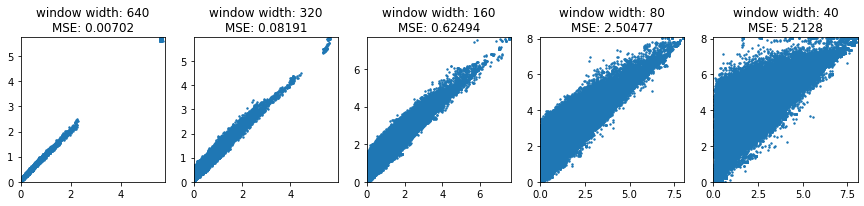

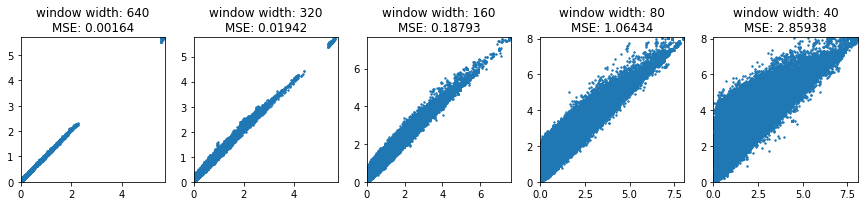

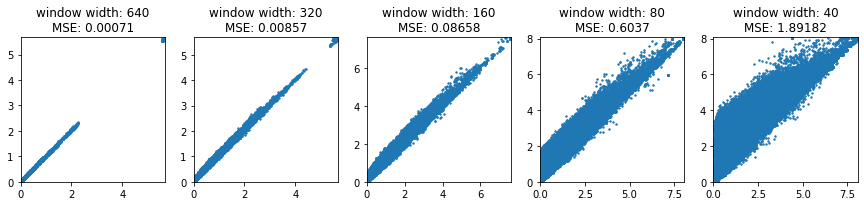

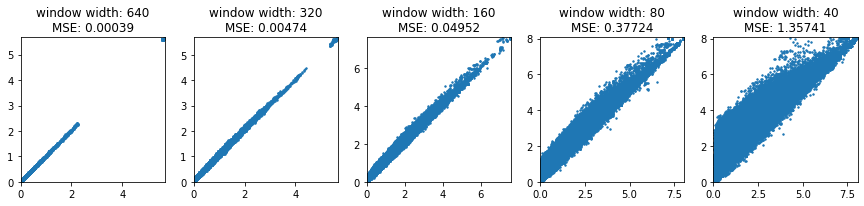

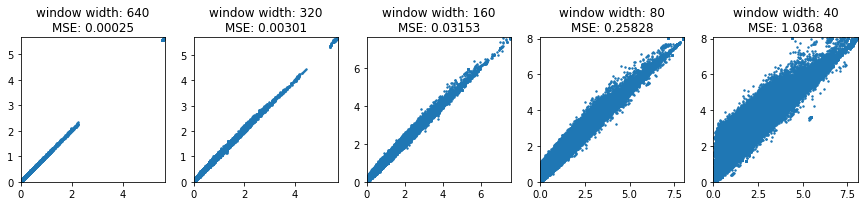

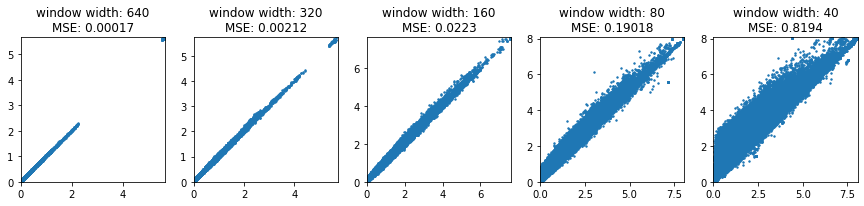

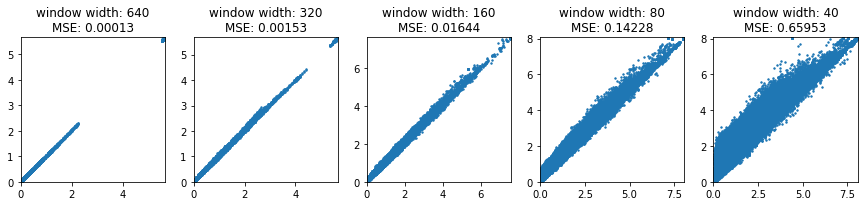

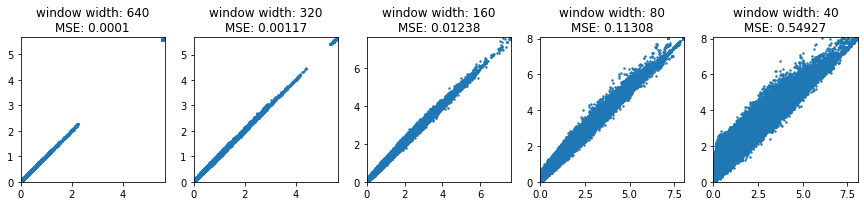

In [151]:
folders = ['1percent', '2percent', '3percent', '4percent', '5percent', '6percent', '7percent', '8percent']

for folder in folders:
    display_kl_accuracy(dict_points_raw[folder], dict_points_comp[folder])

In [ ]:
def find_optimal_window(
    raw_path     = '../Resources/Videos/', 
    comp_path    = '../Results/CompressedVideos/1percent/',
    alpha        = 0.95, 
    lower_bound  = 0, 
    upper_bound  = 640, 
    target       = (0.15, 0.2)
):
    target_met = False
    
    while not target_met:
        width = (lower_bound + upper_bound) // 2
        print('Computing for window width: ' + str(width))
        
        points_raw, points_comp = evaluate_kl_divergence(
            window_width=width, 
            raw_path=raw_path, 
            comp_path=comp_path, 
            alpha=alpha
        )
        
        score = mse(points_raw, points_comp)
        print('MSE: ' + str(np.round(score, 4)))
        
        if score < target[0]:
            upper_bound = width
        elif score > target[1]:
            lower_bound = width
        else:
            target_met = True
        
    return width

In [ ]:
folders = ['1percent', '2percent', '3percent', '4percent', '5percent', '6percent', '7percent', '8percent']

optimal_windows = {}

for folder in folders:
    print('Computing for ' + folder)
    optimal_windows[folder] = find_optimal_window(
        comp_path='../Results/CompressedVideos/' + folder + '/', 
    )

In [154]:
optimal_windows

{'1percent': 240,
 '2percent': 160,
 '3percent': 140,
 '4percent': 110,
 '5percent': 100,
 '6percent': 80,
 '7percent': 75,
 '8percent': 70}

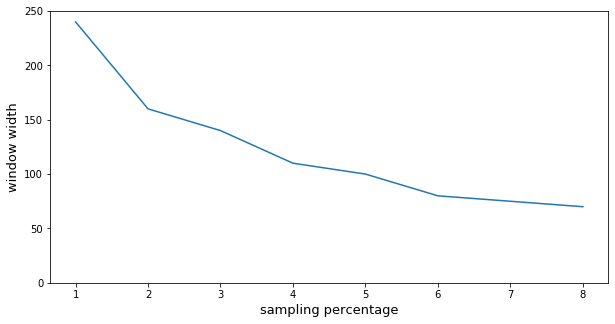

In [189]:
x = list(range(1, len(folders) + 1))
y = list(optimal_windows.values())

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.ylim(0, max(y) + 10)
plt.xlabel('sampling percentage', fontsize=13)
plt.ylabel('window width', fontsize=13);

## Comparing with concatenating channels distributions

### Accuracy

In [ ]:
folder = '1percent'
list_points_concat_raw  = []
list_points_concat_comp = []
window_widths    = [640, 320, 160, 80, 40]
for window_width in window_widths:
    points_raw, points_comp = evaluate_kl_divergence(window_width=window_width, 
                                                     comp_path='../Results/CompressedVideos/' + folder + '/', 
                                                     concatenate=True)
    list_points_concat_raw.append(points_raw)
    list_points_concat_comp.append(points_comp)

In [206]:
print('Mean absolute difference between the two methods for ground truth:', 
      np.mean(np.abs(np.array(list_points_concat_raw) - np.array(dict_points_raw['1percent']))))
print('Mean absolute difference between the two methods for sampled videos:', 
      np.mean(np.abs(np.array(list_points_concat_comp) - np.array(dict_points_comp['1percent']))))

Mean absolute difference between the two methods for ground truth: 2.877904654783927e-16
Mean absolute difference between the two methods for sampled videos: 4.676671101852562e-16


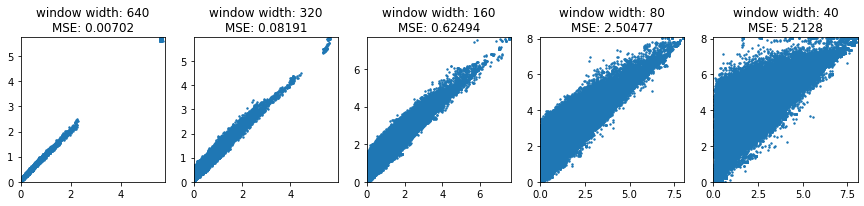

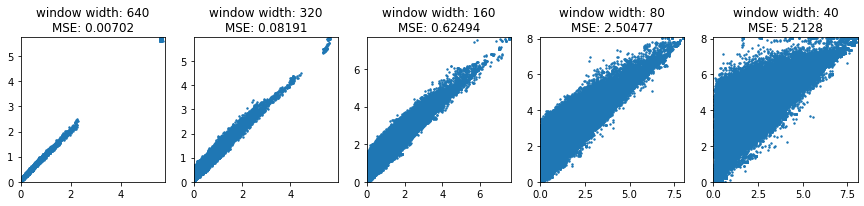

In [196]:
display_kl_accuracy(dict_points_raw['1percent'], dict_points_comp['1percent'])
display_kl_accuracy(list_points_concat_raw, list_points_concat_comp)

### Performance

In [55]:
mean_time = []
flat_time = []

for i in range(1000000):
    mean_a, mean_b = np.random.rand(3, 256), np.random.rand(3, 256)
    flat_a, flat_b = mean_a.flatten(), mean_b.flatten()
    
    st = time.time()
    np.mean([entropy(mean_a[i], mean_b[i]) for i in range(3)])
    mean_time.append(time.time() - st)
    
    st = time.time()
    entropy(flat_a, flat_b)
    flat_time.append(time.time() - st)

tot_mean_time = np.sum(mean_time)
tot_flat_time = np.sum(flat_time)
speedup = np.round(tot_mean_time / tot_flat_time, 2)

print('Time spent computing KL-divergence on the 3 channels:', np.round(tot_mean_time, 2), 'seconds.')
print('Time spent computing KL-divergence on the concatenated channels:', np.round(tot_flat_time, 2), 'seconds')
print('Concatenating the 3 channels before computing the KL-divergence is', speedup, 'times faster.')

Time spent computing KL-divergence on the 3 channels: 63.69 seconds.
Time spent computing KL-divergence on the concatenated channels: 29.38 seconds
Concatenating the 3 channels before computing the KL-divergence is 2.17 times faster.


# JPG Comparison

In [11]:
def jpg_psnr(
    quality = 1
):
    raw_folder = '../Resources/Videos/'
    comp_folder = '../Results/CompressedVideos/jpg/'
    for video in os.listdir(raw_folder):
        Video.jpg_reconstruct(
            raw_folder + video,
            output_dst=comp_folder + video.split('.')[0] + '.mov', 
            quality=quality
        )

    psnr_scores = []
    for raw, comp in zip(os.listdir(raw_folder), os.listdir(comp_folder)):
        psnr_scores.append(Video.psnr(raw_folder + raw, comp_folder + comp))
    
    return psnr_scores

In [ ]:
jpg_psnr_scores = jpg_psnr(quality=3)

In [13]:
print(np.mean(jpg_psnr_scores))

23.731545769610754


# EFAN2D

In [ ]:
folder = '../Results/CompressedVideos/'
for filename in os.listdir(folder):
    video = CompressedVideo(folder + filename)
    video.reconstruct(
        algorithm='efan2d', 
        output_dst='../Results/ReconstructedVideos/EFAN2D/' + filename.split('.')[0] + '.mov', 
        verbose=True
    )

In [ ]:
original_folder = '../Resources/Videos/'
reconstructed_folder = '../Results/ReconstructedVideos/EFAN2D/'

efan2d_psnr_scores = []

for original in os.listdir(original_folder):
    psnr = Video.psnr(
        original_folder + original, 
        reconstructed_folder + original.split('.')[0] + '.mov'
    )
    
    efan2d_psnr_scores.append(psnr)

In [33]:
print('Mean PSNR for EFAN2D:', np.mean(efan2d_psnr_scores))

Mean PSNR for EFAN2D: 21.522601872843556


# EFAN3D

In [ ]:
folder = '../Results/CompressedVideos/'
for filename in os.listdir(folder):
    video = CompressedVideo(folder + filename)
    video.reconstruct(
        algorithm='efan3d', 
        output_dst='../Results/ReconstructedVideos/EFAN3D/' + filename.split('.')[0] + '.mov', 
        verbose=True, 
        num_time_frames=99
    )

In [ ]:
original_folder = '../Resources/Videos/'
reconstructed_folder = '../Results/ReconstructedVideos/EFAN3D/'

efan3d_psnr_scores = []

for original in os.listdir(original_folder):
    psnr = Video.psnr(
        original_folder + original, 
        reconstructed_folder + original.split('.')[0] + '.mov'
    )
    
    efan3d_psnr_scores.append(psnr)

In [59]:
print('Mean PSNR for EFAN3D:', np.mean(efan3d_psnr_scores))

Mean PSNR for EFAN3D: 24.4117432246204


# ADEFAN

### Vanilla

In [ ]:
folder = '../Results/CompressedVideos/'
for filename in os.listdir(folder):
    video = CompressedVideo(folder + filename)
    video.reconstruct(
        algorithm='adefan', 
        output_dst='../Results/ReconstructedVideos/ADEFAN/vanilla/' + filename.split('.')[0] + '.mov', 
        verbose=True, 
        num_time_frames=99, 
        beta=10
    )

In [ ]:
original_folder = '../Resources/Videos/'
reconstructed_folder = '../Results/ReconstructedVideos/ADEFAN/vanilla/'

adefan_vanilla_psnr_scores = []

for original in os.listdir(original_folder):
    psnr = Video.psnr(
        original_folder + original, 
        reconstructed_folder + original.split('.')[0] + '.mov'
    )
    
    adefan_vanilla_psnr_scores.append(psnr)

In [63]:
print('Mean PSNR for ADEFAN vanilla:', np.mean(adefan_vanilla_psnr_scores))

Mean PSNR for ADEFAN vanilla: 25.11006062159698


### Gaussian Averaging

In [ ]:
folder = '../Results/CompressedVideos/'
for filename in os.listdir(folder):
    video = CompressedVideo(folder + filename)
    video.reconstruct(
        algorithm='adefan', 
        output_dst='../Results/ReconstructedVideos/ADEFAN/gaussian_avg/' + filename.split('.')[0] + '.mov', 
        avg_method='gaussian', 
        verbose=True, 
        num_time_frames=99, 
        beta=10
    )

In [ ]:
original_folder = '../Resources/Videos/'
reconstructed_folder = '../Results/ReconstructedVideos/ADEFAN/gaussian_avg/'

adefan_gaussian_psnr_scores = []

for original in os.listdir(original_folder):
    psnr = Video.psnr(
        original_folder + original, 
        reconstructed_folder + original.split('.')[0] + '.mov'
    )
    
    adefan_gaussian_psnr_scores.append(psnr)

In [69]:
print('Mean PSNR for ADEFAN gaussian_avg:', np.mean(adefan_gaussian_psnr_scores))

Mean PSNR for ADEFAN gaussian_avg: 25.13123261807901


### Filtering by window

In [ ]:
folder = '../Results/CompressedVideos/'
i = 0
for filename in os.listdir(folder):
    i += 1
    if i >= 36:
        video = CompressedVideo(folder + filename)
        video.reconstruct(
            algorithm='adefan', 
            output_dst='../Results/ReconstructedVideos/ADEFAN/window_filtering/' + filename.split('.')[0] + '.mov', 
            filter_type='window', 
            verbose=True, 
            num_time_frames=99, 
            beta=10
        )

In [ ]:
original_folder = '../Resources/Videos/'
reconstructed_folder = '../Results/ReconstructedVideos/ADEFAN/window_filtering/'

adefan_window_psnr_scores = []
names = []

for original in os.listdir(original_folder):
    psnr = Video.psnr(
        original_folder + original, 
        reconstructed_folder + original.split('.')[0] + '.mov'
    )
    
    adefan_window_psnr_scores.append(psnr)
    names.append(original)

In [8]:
print('Mean PSNR for ADEFAN window:', np.mean(adefan_window_psnr_scores))

Mean PSNR for ADEFAN window: 25.132250571958533


### Filtering by window and Gaussian Averaging

In [ ]:
folder = '../Results/CompressedVideos/'
for filename in os.listdir(folder):
    video = CompressedVideo(folder + filename)
    video.reconstruct(
        algorithm='adefan', 
        output_dst='../Results/ReconstructedVideos/ADEFAN/window_filtering_gaussian_avg/' + filename.split('.')[0] + '.mov', 
        filter_type='window', 
        avg_method='gaussian', 
        verbose=True, 
        num_time_frames=99, 
        beta=10
    )

In [ ]:
original_folder = '../Resources/Videos/'
reconstructed_folder = '../Results/ReconstructedVideos/ADEFAN/window_filtering_gaussian_avg/'

adefan_gaussian_window_psnr_scores = []

for original in os.listdir(original_folder):
    psnr = Video.psnr(
        original_folder + original, 
        reconstructed_folder + original.split('.')[0] + '.mov'
    )
    
    adefan_gaussian_window_psnr_scores.append(psnr)

In [10]:
print('Mean PSNR for ADEFAN gaussian and window:', np.mean(adefan_gaussian_window_psnr_scores))

Mean PSNR for ADEFAN gaussian and window: 25.133267910744255


### Filtering by window, Gaussian Averaging and Variable Sigma Time

In [ ]:
folder = '../Results/CompressedVideos/'
for filename in os.listdir(folder):
    video = CompressedVideo(folder + filename)
    video.reconstruct(
        algorithm='adefan', 
        output_dst='../Results/ReconstructedVideos/ADEFAN/window_filtering_gaussian_avg_variable_sigma_time/' + \
            filename.split('.')[0] + '.mov', 
        filter_type='window', 
        avg_method='gaussian', 
        kernel_type='variable', 
        verbose=True, 
        num_time_frames=99, 
        beta=10
    )

In [ ]:
original_folder = '../Resources/Videos/'
reconstructed_folder = '../Results/ReconstructedVideos/ADEFAN/window_filtering_gaussian_avg_variable_sigma_time/'

adefan_gaussian_window_sigma_psnr_scores = []

for original in os.listdir(original_folder):
    psnr = Video.psnr(
        original_folder + original, 
        reconstructed_folder + original.split('.')[0] + '.mov'
    )
    
    adefan_gaussian_window_sigma_psnr_scores.append(psnr)

In [13]:
print('Mean PSNR for ADEFAN gaussian, window and variable sigma_time:', np.mean(adefan_gaussian_window_sigma_psnr_scores))

Mean PSNR for ADEFAN gaussian, window and variable sigma_time: 25.372016600214508


# Beta parameter optimization

In [ ]:
folder = '../Results/CompressedVideos/'
original_folder = '../Resources/Videos/'
reconstructed_folder = '../Results/ReconstructedVideos/ADEFAN/window_filtering_gaussian_avg_variable_sigma_time/'
betas = [2, 4, 8, 10, 13, 14, 15, 16, 17, 20]
adefan_gaussian_window_sigma_psnr_scores = {}

for beta in betas:
    psnr_scores = []
    
    for filename in os.listdir(folder):
        video = CompressedVideo(folder + filename)
        video.reconstruct(
            algorithm='adefan', 
            output_dst='../Results/ReconstructedVideos/ADEFAN/window_filtering_gaussian_avg_variable_sigma_time/' + \
                filename.split('.')[0] + '.mov', 
            filter_type='window', 
            avg_method='gaussian', 
            kernel_type='variable', 
            verbose=True, 
            num_time_frames=99, 
            beta=beta
        )

    for original in os.listdir(original_folder):
        psnr = Video.psnr(
            original_folder + original, 
            reconstructed_folder + original.split('.')[0] + '.mov'
        )
        
        psnr_scores.append(psnr)

    adefan_gaussian_window_sigma_psnr_scores[str(beta)] = np.mean(psnr_scores)
    
    print('Mean PSNR with beta =', beta, ':', np.mean(adefan_gaussian_window_sigma_psnr_scores[str(beta)]))

In [7]:
adefan_gaussian_window_sigma_psnr_scores

{'2': 25.0198975455897,
 '4': 25.237925445564944,
 '8': 25.44212026795923,
 '10': 25.48751584628821,
 '13': 25.515125434401757,
 '14': 25.516524514278743,
 '15': 25.514205764319808,
 '16': 25.50803589598638,
 '17': 25.499188756892636,
 '20': 25.46074076304402}

# Compute optimal PSNR for ADEFAN

In [ ]:
folder = '../Results/CompressedVideos/'
original_folder = '../Resources/Videos/'
reconstructed_folder = '../Results/ReconstructedVideos/ADEFAN/window_filtering_gaussian_avg_variable_sigma_time/'
adefan_gaussian_window_sigma_psnr_scores = {}

psnr_scores = []

for filename in os.listdir(folder):
    video = CompressedVideo(folder + filename)
    video.reconstruct(
        algorithm='adefan', 
        output_dst='../Results/ReconstructedVideos/ADEFAN/window_filtering_gaussian_avg_variable_sigma_time/' + \
            filename.split('.')[0] + '.mov', 
        filter_type='window', 
        avg_method='gaussian', 
        kernel_type='variable', 
        verbose=True, 
        num_time_frames=99
    )

for original in os.listdir(original_folder):
    psnr = Video.psnr(
        original_folder + original, 
        reconstructed_folder + original.split('.')[0] + '.mov'
    )

    psnr_scores.append(psnr)

optimal_psnr = np.mean(psnr_scores)

In [5]:
print('Optimal PSNR for ADEFAN:', optimal_psnr)

Optimal PSNR for ADEFAN: 25.554743849088748


# Compute Results for all methods with different percentages

In [ ]:
def compute_results(fraction):
    fraction_folder = str(int(fraction * 100)) + 'percent'
    
    folder = '../Results/CompressedVideos/' + fraction_folder + '/'
    original_folder = '../Resources/Videos/'
    reconstructed_folder = '../Results/ReconstructedVideos/'
    
    num_videos = len(os.listdir(original_folder))
    
    print('Compressing videos')
    i = 0
    print(str(i) + '/' + str(num_videos), end='\r')
    for video in os.listdir(original_folder):
        Video.compress(original_folder + video, fraction=fraction)
        i += 1
        print(str(i) + '/' + str(num_videos), end='\r')
    print('')
    
    print('EFAN2D')
    i = 0
    print(str(i) + '/' + str(num_videos), end='\r')
    for filename in os.listdir(folder):
        video = CompressedVideo(folder + filename)
        video.reconstruct(
            algorithm='efan2d', 
            output_dst=reconstructed_folder + fraction_folder + '/efan2d/' + filename.split('.')[0] + '.mov'
        )
        i += 1
        print(str(i) + '/' + str(num_videos), end='\r')
    print('')
    
    print('EFAN3D')
    i = 0
    print(str(i) + '/' + str(num_videos), end='\r')
    for filename in os.listdir(folder):
        video = CompressedVideo(folder + filename)
        video.reconstruct(
            algorithm='efan3d', 
            output_dst=reconstructed_folder + fraction_folder + '/efan3d/' + filename.split('.')[0] + '.mov', 
            num_time_frames=99
        )
        i += 1
        print(str(i) + '/' + str(num_videos), end='\r')
    print('')
    
    print('ADEFAN')
    i = 0
    for filename in os.listdir(folder):
        video = CompressedVideo(folder + filename)
        video.reconstruct(
            algorithm='adefan', 
            output_dst=reconstructed_folder + fraction_folder + '/adefan/' + filename.split('.')[0] + '.mov', 
            filter_type='window', 
            avg_method='gaussian'
            num_time_frames=99
        )
        i += 1
        print(str(i) + '/' + str(num_videos), end='\r')
    print('')

In [ ]:
original_folder = '../Resources/Videos/'
reconstructed_folder = '../Results/ReconstructedVideos/'

psnr = {}

fractions = [i / 100 for i in range(1, 9)]

for fraction in fractions:
    fraction_folder = str(int(fraction * 100)) + 'percent'
    psnr[fraction_folder] = {'efan2d': [], 'efan3d': [], 'adefan': []}
    

for original in os.listdir(original_folder):
    for fraction in fractions:
        fraction_folder = str(int(fraction * 100)) + 'percent'
        
        psnr_efan2d = Video.psnr(
            original_folder + original, 
            reconstructed_folder + fraction_folder + '/efan2d/' + original.split('.')[0] + '.mov'
        )

        psnr[fraction_folder]['efan2d'].append(psnr_efan2d)
        
        psnr_efan3d = Video.psnr(
            original_folder + original, 
            reconstructed_folder + fraction_folder + '/efan3d/' + original.split('.')[0] + '.mov'
        )

        psnr[fraction_folder]['efan3d'].append(psnr_efan3d)
        
        psnr_adefan = Video.psnr(
            original_folder + original, 
            reconstructed_folder + fraction_folder + '/adefan/' + original.split('.')[0] + '.mov'
        )

        psnr[fraction_folder]['adefan'].append(psnr_adefan)

In [ ]:
psnr